In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

Mounted at /content/drive


#functions

In [ ]:
class RNN:
  def __init__(self, k=1, m=100, eta=0.1, seq_length=25, sig=0.01):
    self.m = m  # Dimensionality of hidden state
    self.eta = eta  # Learning rate
    self.seq_length = seq_length  # Length of training sequences
    self.b = np.zeros((m, 1))  # Bias vector b
    self.c = np.zeros((k, 1))  # Bias vector c
    self.U = np.random.rand(m, k) * sig  # Weight matrix u
    self.W = np.random.rand(m, m) * sig  # Weight matrix w
    self.V = np.random.rand(k, m) * sig  # Weight matrix v

In [ ]:
def char_num_convert(unique_characters):
  char_2_idx={}
  idx_2_char={}
  for idx,char in enumerate(unique_characters):
    char_2_idx[char]=idx
    idx_2_char[idx]=char
  return char_2_idx,idx_2_char


def softmax(x):
  return np.exp(x)/np.sum(np.exp(x),axis=0)


def one_hot(char,unique_characters):
  k=len(unique_characters)
  char_2_idx,idx_2_char=char_num_convert(unique_characters)
  number=char_2_idx[char]
  return np.identity(k)[number]


def synthesis_sequence(rnn,h_0,x_0,n,unique_characters):
  x=np.copy(x_0)
  h=np.copy(h_0)
  k=x.shape[0]
  samples=[]
  for i in range(n):
    a_t=rnn.W@h+rnn.U@x+rnn.b
    h=np.tanh(a_t)
    o_t=rnn.V@h+rnn.c
    p_t=softmax(o_t)
    cp=np.cumsum(p_t,axis=0)
    a=np.random.uniform(0,1,1)
    ixs=np.argwhere(cp-a>0)
    ii=ixs[0][0]
    x=one_hot(idx_2_char[ii],unique_characters)
    sample=idx_2_char[ii]
    samples.append(sample)
  sentence=''.join(samples)
  return sentence

def computeLoss(Y,p):
  return -np.sum(np.log(np.sum(Y*p,axis=1)))

In [ ]:
def forward(rnn,x,h_0):
  h_t=np.zeros((x.shape[0],h_0.shape[0]))#24，100
  a_t=np.zeros((x.shape[0],h_0.shape[0]))#24，100
  prob_t=np.zeros((x.shape[0],rnn.V.shape[0]))#24,80
  for t in range(x.shape[0]):
    if t==0:
      a=rnn.W@h_0[:,np.newaxis]+rnn.U@x[t][:,np.newaxis]+rnn.b
    else:
      a=rnn.W@h_t[t-1][:,np.newaxis]+rnn.U@x[t][:,np.newaxis]+rnn.b
    a_t[t][:,np.newaxis]=a
    h_t[t][:,np.newaxis]=np.tanh(a)
    o_t=rnn.V@h_t[t][:,np.newaxis]+rnn.c
    p=softmax(o_t)
    prob_t[t][:,np.newaxis]=p
  
  return a_t,h_t,prob_t

In [ ]:
def backpropagation(rnn,Y,a,p,h,h_prev,X):
  grads=RNN()
  grad_h=np.zeros([h.shape[0],h.shape[1]])#24 100
  grad_a=np.zeros([a.shape[0],a.shape[1]])#24,100
  grad_o=-(Y-p)#24 80
  grad_h[-1,:]=grad_o[-1,:][np.newaxis,:]@rnn.V#1,80 @ 80 100  == 1,100
  grad_a[-1,:]=grad_h[-1,:][np.newaxis,:]@np.diag(1-np.power(np.tanh(a[-1,:]),2))# 1,100@  diag((100)^2)
  grads.V=grad_o.T@h
  for t in reversed(range(Y.shape[0]-1)):#22-->0
    grad_h[t,:]=grad_o[t,:][np.newaxis,:]@rnn.V+grad_a[t+1][np.newaxis,:]@rnn.W#1,80@80,100+1,100@100,100
    grad_a[t,:]=grad_h[t,:][np.newaxis,:]@np.diag(1-np.power(np.tanh(a[t,:]),2))
  grads.b=np.copy(np.sum(grad_a,axis=0)[:,np.newaxis])
  grads.c=np.copy(np.sum(grad_o,axis=0)[:,np.newaxis])
  h_no_last=np.delete(h,-1,axis=0)
  h_prev=np.concatenate((h_prev[np.newaxis,:],h_no_last),axis=0)
  grads.W=grad_a.T@h_prev
  grads.U=grad_a.T@X

  return grads

In [ ]:
def AdaGrad(m_old,g,param_old,eta):
  m=m_old+np.power(g,2)
  param=param_old-(eta / np.sqrt(m+np.finfo('float').eps)) * g
  return m,param

In [ ]:
def computeGrads(rnn, x, y, step=1e-4):
  res_rnn = copy.deepcopy(rnn)
  h_prev = np.zeros(rnn.m)
  for idx, att in enumerate(['b', 'c', 'U', 'W', 'V']):
    grad = np.zeros(getattr(rnn, att).shape)
    for i in range(grad.shape[0]):
      for j in range(grad.shape[1]):
        rnn_try = copy.deepcopy(rnn)
        aux = np.copy(getattr(rnn_try, att))
        aux[i,j]-=step
        setattr(rnn_try, att, aux)
        a,h,p=forward(rnn_try,x,h_prev)
        l1=computeLoss(y, p)
        rnn_try=copy.deepcopy(rnn)
        aux=np.copy(getattr(rnn_try, att))
        aux[i,j]+=step
        setattr(rnn_try, att, aux)
        a,h,p =forward(rnn_try,x,h_prev)
        l2 = computeLoss(y, p)
        grad[i, j] = (l2 - l1) / (2 * step)
    setattr(res_rnn, att, grad)
  return res_rnn

In [ ]:
def synthesizing(rnn, h_0, x_0, n):
  x = np.copy(x_0)[:,np.newaxis]
  h = np.copy(h_0)[:, np.newaxis]
  samples = np.zeros((x_0.shape[0], n))
  for t in range(n):
    a = rnn.W @ h + rnn.U @ x + rnn.b
    h = np.tanh(a)
    o = rnn.V @ h + rnn.c
    p = softmax(o)
    choice = np.random.choice(range(x.shape[0]), 1, p=p.flatten())  # Select random character
    # according to probabilities
    x = np.zeros(x.shape)
    x[choice] = 1
    samples[:, t] = x.flatten()

  return samples

In [ ]:
file='/content/drive/My Drive/goblet_book.txt'
file=open(file,'r')
characters=file.read()
unique_characters=set(characters)
char_2_idx,idx_2_char=char_num_convert(unique_characters)
import numpy as np
import copy
k=len(unique_characters)
rnn=RNN(k=k,m=5)
h_0=np.zeros(rnn.m)
x_0=one_hot('.',unique_characters)
samples=synthesis_sequence(rnn,h_0=h_0,x_0=x_0,n=25,unique_characters=unique_characters)

unique_characters=set(characters)
X_chars=characters[1:rnn.seq_length]
Y_chars=characters[2:rnn.seq_length+1]
Xt=[]
Yt=[]

for i in range(len(X_chars)):
  Xt.append(one_hot(X_chars[i],unique_characters))
  X=np.array(Xt)

for i in range(len(Y_chars)):
  Yt.append(one_hot(Y_chars[i],unique_characters))
  Y=np.array(Yt)
a,h,p=forward(rnn,X,h_0)
grads=backpropagation(rnn,Y,a,p,h,h_0,X)
rnn_test=computeGrads(rnn,X,Y,1e-4)

In [ ]:
print(np.mean(abs(grads.b - rnn_test.b)))
print(np.mean(abs(grads.c - rnn_test.c)))
print(np.mean(abs(grads.U - rnn_test.U)))
print(np.mean(abs(grads.V - rnn_test.V)))
print(np.mean(abs(grads.W - rnn_test.W)))


6.651523702487506e-11
4.858335719837292e-10
5.862710651879797e-12
3.6515856156291466e-11
4.766175087323754e-11


In [ ]:
def Adam(param_old,g_t,s_old,v_old,eta,beta_1_now,beta_2_now,beta_1=0.9,beta_2=0.999):
  v_t=beta_1*v_old+(1-beta_1)*g_t
  s_t=beta_2*s_old+(1-beta_2)*np.power(g_t,2)
 
  beta_1_now=beta_1_now*beta_1
  beta_2_now=beta_2_now*beta_2
  v_hat=v_t/(1-beta_1_now)
  s_hat=s_t/(1-beta_2_now)
  g_t_prime=eta*v_hat/(np.sqrt(s_hat)+np.finfo('float').eps)
  param=param_old-g_t_prime
  return beta_1_now,beta_2_now,s_t,v_t,param


#main


In [ ]:
file='/content/drive/My Drive/goblet_book.txt'
file=open(file,'r')
characters=file.read()
import numpy as np
unique_characters=set(characters)

In [ ]:
char_2_idx,idx_2_char=char_num_convert(unique_characters)

In [ ]:
k=len(unique_characters)
rnn=RNN(k=k)
h_0=np.zeros(rnn.m)
x_0=one_hot('.',unique_characters)
samples=synthesis_sequence(rnn,h_0=h_0,x_0=x_0,n=25,unique_characters=unique_characters)

In [ ]:
X_chars=characters[1:rnn.seq_length]
Y_chars=characters[2:rnn.seq_length+1]
Xt=[]
Yt=[]
for i in range(len(X_chars)):
  Xt.append(one_hot(X_chars[i],unique_characters))
  X=np.array(Xt)

for i in range(len(Y_chars)):
  Yt.append(one_hot(Y_chars[i],unique_characters))
  Y=np.array(Yt)

#adagrad


In [ ]:
from tqdm import tqdm
import copy
e=0
m_list=[0,0,0,0,0]
full_iter=len(characters)-25
h_prev=np.zeros(rnn.m)
loss_list=[]
smooth_loss=0
best_rnn=RNN(k=k)
rnn=RNN(k=k)
best_loss=float('inf')

for epoch in tqdm(range(7)):
  while e <= full_iter:
    X_chars=characters[e:e+rnn.seq_length-1]
    Y_chars=characters[e+1:e+rnn.seq_length]
    Xt=[]
    Yt=[]
    for i in range(len(X_chars)):
      Xt.append(one_hot(X_chars[i],unique_characters))
    X=np.array(Xt)
    for i in range(len(Y_chars)):
      Yt.append(one_hot(Y_chars[i],unique_characters))
    Y=np.array(Yt)
    a,h,p=forward(rnn,X,h_prev)
    grads=backpropagation(rnn,Y,a,p,h,h_prev,X)
    h_prev=h[-1]
    for idx,attr in enumerate(['b','c','U','V','W']):
      grad=getattr(grads,attr)
      grad=np.clip(grad,-5,5)
      m_val,attr_new=AdaGrad(m_list[idx],grad,getattr(rnn,attr),rnn.eta)
      setattr(rnn,attr,attr_new)
      m_list[idx]=m_val
    if e==0 and epoch==0:
      smooth_loss=computeLoss(Y,p)
      loss_list.append(smooth_loss)
      best_rnn=copy.deepcopy(rnn)
      best_loss=smooth_loss
    else:
      smooth_loss=0.999*smooth_loss+0.001*computeLoss(Y,p)
      if smooth_loss<best_loss:
        best_rnn=copy.deepcopy(rnn)
        best_loss=smooth_loss
      if e%(rnn.seq_length *100)==0:
        loss_list.append(smooth_loss)
    print(smooth_loss)
    e+=rnn.seq_length
  e=0
  h_prev=np.zeros(h_prev.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

105.16576484770897
105.1652142345048
105.42282398653309
105.70227785886566
105.85259205800085
106.02077045000115
106.21115399160503
106.3987824827151
106.4668421581156
106.58818845925023
106.68195761936242
106.73533525094167
106.7732216034923
106.84265710201417
106.93115132678673
106.94531760814976
106.97890306477504
106.98690868476262
107.00401562883538
107.00561373895175
107.02678306270431
107.02132443105886
107.04521451217762
107.0557985920467
107.05527332848672
107.04627680717269
107.06369039824071
107.06551333638593
107.06483621986565
107.07299478309974
107.07165757267698
107.06927971937539
107.08153861166862
107.08415010143578
107.08310543489169
107.0992925805423
107.08772674575891
107.07759862474941
107.07392660780512
107.0714402155617
107.073261892455
107.077893283001
107.06624768616723
107.04943486769031
107.04911690743475
107.03734867084157
107.02641799355092
107.01670878975271
107.00713389677455
107.00608953542091
106.99496058838335
106.98595895739118
106.97866626694517
107.

  0%|          | 0/7 [00:03<?, ?it/s]

98.87903893238924


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_list)) * 100, loss_list)
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.show()

In [ ]:
x_0 = one_hot('T', char_2_idx)
print("Lowest loss: " + str(best_loss))
h_prev = np.zeros(rnn.m)
samples = synthesizing(best_rnn, h_prev, x_0, 5000)
samples = [idx_2_char[int(np.argmax(samples[:,n]))] for n in range(samples.shape[1])]
print("\n")
print("".join(samples))
print("\n")

#adam


In [ ]:
from tqdm import tqdm
import copy
e=0
m_list=[0,0,0,0,0]
full_iter=len(characters)-25
h_prev=np.zeros(rnn.m)
loss_list=[]
smooth_loss=0
best_rnn=RNN(k=k)
rnn=RNN(k=k)
best_loss=float('inf')
beta_1_t=[1,1,1,1,1]
beta_2_t=[1,1,1,1,1]
s_list=[0,0,0,0,0]
v_list=[0,0,0,0,0]
eta=0.001
for epoch in tqdm(range(2)):
  while e <= 10000:
    X_chars=characters[e:e+rnn.seq_length-1]
    Y_chars=characters[e+1:e+rnn.seq_length]
    Xt=[]
    Yt=[]
    for i in range(len(X_chars)):
      Xt.append(one_hot(X_chars[i],unique_characters))
    X=np.array(Xt)
    for i in range(len(Y_chars)):
      Yt.append(one_hot(Y_chars[i],unique_characters))
    Y=np.array(Yt)
    a,h,p=forward(rnn,X,h_prev)
    grads=backpropagation(rnn,Y,a,p,h,h_prev,X)
    h_prev=h[-1]
    for idx,attr in enumerate(['b','c','U','V','W']):
      grad=getattr(grads,attr)
      grad=np.clip(grad,-5,5)
      #print(grad)
      beta_1_val,beta_2_val,s_val,v_val,attr_new=Adam(getattr(rnn,attr),grad,s_list[idx],v_list[idx],eta,beta_1_t[idx],beta_2_t[idx],beta_1=0.9,beta_2=0.999)
      setattr(rnn,attr,attr_new)
      s_list[idx]=s_val
      v_list[idx]=v_val
      beta_1_t[idx]=beta_1_val
      beta_2_t[idx]=beta_2_val
    if e==0 and epoch==0:
      smooth_loss=computeLoss(Y,p)
      loss_list.append(smooth_loss)
      best_rnn=copy.deepcopy(rnn)
      best_loss=smooth_loss
    else:
      smooth_loss=0.999*smooth_loss+0.001*computeLoss(Y,p)
      if smooth_loss<best_loss:
        best_rnn=copy.deepcopy(rnn)
        best_loss=smooth_loss
      if e%(rnn.seq_length *100)==0:
        loss_list.append(smooth_loss)
    print(smooth_loss)
    e+=rnn.seq_length
  e=0
  h_prev=np.zeros(h_prev.shape)

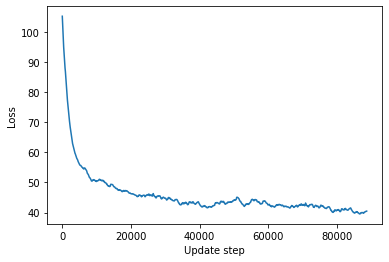

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_list)) * 100, loss_list)
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.show()

In [ ]:
x_0 = one_hot('T', char_2_idx)
print("Lowest loss: " + str(best_loss))
h_prev = np.zeros(rnn.m)
samples = synthesizing(best_rnn, h_prev, x_0, 5000)
samples = [idx_2_char[int(np.argmax(samples[:,n]))] for n in range(samples.shape[1])]
print("\n")
print("".join(samples))
print("\n")

Lowest loss: 39.52779644842633


his usuely armon to keceving at priting awn you tom."
That park eround with he said had tave as namen she ag Sefore. . . his pargectearcing to some his claiving with nave your kis and Harry. He wluds of the poce and when I wands.  Shappeap." has Plime," He.
THarysamet the sharred, takighto meref recoor hapeed him peace to expected for him ho besely.  Theid Worst rase, I wd was that lookion, saight...
Hurry walking to kiep?  There retrace toway bealfed to chistand ur-bye smarical to me hen a moned airconedur to the only, nistarainging and formaking thead what cast bood night bes opent he goved the owlvine lake . . . a read was "of Won, Dumbonagolforosmally.  Snindor said from at Dumbledore faicing, ack as the eamal you apteale, hope."
"If they said bedore andom as his necoving.  He seement.  SHarry.  He as aming-eace ode."
Harry was bearoverishow to mading lique to the powious," said of ald magried arounnistand at Harry.  Thious had have alxpeptong," ...

#random


In [ ]:
import random
random.randint(0,100)

46

In [ ]:
from tqdm import tqdm
import copy
m_list=[0,0,0,0,0]
full_iter=len(characters)-25
h_prev=np.zeros(rnn.m)
loss_list=[]
smooth_loss=0
best_rnn=RNN(k=k)
rnn=RNN(k=k)
best_loss=float('inf')
beta_1_t=[1,1,1,1,1]
beta_2_t=[1,1,1,1,1]
s_list=[0,0,0,0,0]
v_list=[0,0,0,0,0]
eta=0.001
for epoch in tqdm(range(1)):
  for i in range(80000):
    if i==0:
      e=0 
    else:
      e=random.randint(0,full_iter)
    X_chars=characters[e:e+rnn.seq_length-1]
    Y_chars=characters[e+1:e+rnn.seq_length]
    Xt=[]
    Yt=[]
    for i in range(len(X_chars)):
      Xt.append(one_hot(X_chars[i],unique_characters))
    X=np.array(Xt)
    for i in range(len(Y_chars)):
      Yt.append(one_hot(Y_chars[i],unique_characters))
    Y=np.array(Yt)
    a,h,p=forward(rnn,X,h_prev)
    h_prev=np.zeros(rnn.m)
    grads=backpropagation(rnn,Y,a,p,h,h_prev,X)
    
    for idx,attr in enumerate(['b','c','U','V','W']):
      grad=getattr(grads,attr)
      grad=np.clip(grad,-5,5)
      #print(grad)
      beta_1_val,beta_2_val,s_val,v_val,attr_new=Adam(getattr(rnn,attr),grad,s_list[idx],v_list[idx],eta,beta_1_t[idx],beta_2_t[idx],beta_1=0.9,beta_2=0.999)
      setattr(rnn,attr,attr_new)
      s_list[idx]=s_val
      v_list[idx]=v_val
      beta_1_t[idx]=beta_1_val
      beta_2_t[idx]=beta_2_val
    if e==0 and epoch==0:
      smooth_loss=computeLoss(Y,p)
      loss_list.append(smooth_loss)
      best_rnn=copy.deepcopy(rnn)
      best_loss=smooth_loss
    else:
      smooth_loss=0.999*smooth_loss+0.001*computeLoss(Y,p)
      if smooth_loss<best_loss:
        best_rnn=copy.deepcopy(rnn)
        best_loss=smooth_loss
      
      loss_list.append(smooth_loss)
    print(smooth_loss)
  e=0
  h_prev=np.zeros(h_prev.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

105.16878729083041
105.16878832434494
105.16876420185032
105.16867971911732
105.16857148341752
105.16836542720732
105.16800821331837
105.16742655757827
105.1663814668417
105.16454571032986
105.16126532351585
105.15629644666433
105.14735033842439
105.13446586332353
105.12128851350259
105.10569552496484
105.08799252944758
105.06961513593004
105.05484964242787
105.03436195660669
105.01383669924957
104.98941146344863
104.96284008617059
104.93928674208156
104.91930775926846
104.88826758538617
104.87553237931185
104.84537825015678
104.81644874840411
104.7878938122249
104.75885704983793
104.72559000885373
104.7050160978623
104.68307795797853
104.65883141387683
104.6333114748547
104.60600860603738
104.5726046895029
104.55636186434444
104.532210902399
104.50836886919976
104.47828704994038
104.44393224477254
104.41726952545855
104.39021143604467
104.36188224510269
104.33630483520251
104.32074153864518
104.29844236698665
104.26980863690355
104.23714697430583
104.21478505032348
104.19092267252707


  0%|          | 0/1 [00:02<?, ?it/s]

97.89606914720946
97.87053699446845
97.85044281767972
97.82280716029705
97.80081917410122
97.77379579198724
97.74855408760718
97.71980070047455
97.69221672486717
97.66872468056415
97.65709573550912
97.63707307773103
97.61358767071559
97.58422598619086
97.56944026781126
97.54146395149805
97.52395476899801
97.49490516506057


KeyboardInterrupt: ignored

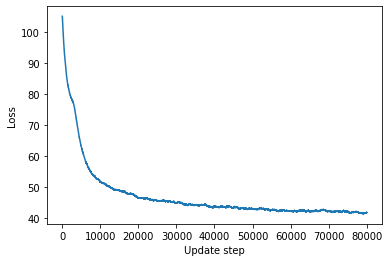

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.show()

In [ ]:
x_0 = one_hot('T', char_2_idx)
print("Lowest loss: " + str(best_loss))
h_prev = np.zeros(rnn.m)
samples = synthesizing(best_rnn, h_prev, x_0, 5000)
samples = [idx_2_char[int(np.argmax(samples[:,n]))] for n in range(samples.shape[1])]
print("\n")
print("".join(samples))
print("\n")

Lowest loss: 39.98595491934192


hink of his facusined in the still His lave day'll ressen gargarovan, out of said Harry, whime he crenoric's hoy haid terlintion new Lorwing with unsaway pace.
"Ah Helfols mars, Potter abnevins, herssons ex-mistand. "What he has really and Flehsid prostes was mander to sag front him.
It my been Crable you hearry. . . . the come aztip to go on the eare!"  said Ron the skilled.
"But his heam.  A nisto looking at the boompion be all the sean dis. Yeved-surterfued. "Dobby told of findy wozze some drestime a fillen his looking roop, I've right, sor who wold at the can't approwards; neck eye.
"But were gave thosped tose echul.  Itm that'blar cond.  The there?"  said Ron'll readled.  It's backed the Come. . . .
"I sit the doben, and Azkackled Mr. Croung to severing lis exame in the saw low. . . . this morlit'd Ron," said Harry.  "I' the stopped ta dand to hold him.
Dumbledoring hit them, sprowl at and Gertted they to sithost though the said VoldemTry, with the

#random trunc


In [ ]:
from tqdm import tqdm
import random

import copy

full_iter=len(characters)-25
h_prev=np.zeros(rnn.m)
loss_list=[]
smooth_loss1=0
k=80
best_rnn=RNN(k=k)
rnn=RNN(k=k)
best_loss=float('inf')
beta_1_t=[1,1,1,1,1]
beta_2_t=[1,1,1,1,1]
s_list=[0,0,0,0,0]
v_list=[0,0,0,0,0]
eta=0.001
chunk_num=10000
chunk_size=int(full_iter/chunk_num)-1
batch_size=3
for epoch in tqdm(range(1)):
  for i in range(chunk_num):
    ith_chunk=random.randint(1,chunk_num-1)
    e=(ith_chunk-1)*chunk_size
    Xt=[]
    Yt=[]
    while e < ith_chunk*chunk_size:

      X_chars=characters[e:e+rnn.seq_length-1]
      Y_chars=characters[e+1:e+rnn.seq_length]

      for j in range(len(X_chars)):
        Xt.append(one_hot(X_chars[j],unique_characters))
      X=np.array(Xt)
      for k in range(len(Y_chars)):
        Yt.append(one_hot(Y_chars[k],unique_characters))
      Y=np.array(Yt)
      e+=rnn.seq_length
      a,h,p=forward(rnn,X,h_prev)
      grads=backpropagation(rnn,Y,a,p,h,h_prev,X)
        
      for idx,attr in enumerate(['b','c','U','V','W']):
        grad=getattr(grads,attr)
        grad=np.clip(grad,-5,5)
        #print(grad)
        beta_1_val,beta_2_val,s_val,v_val,attr_new=Adam(getattr(rnn,attr),grad,s_list[idx],v_list[idx],eta,beta_1_t[idx],beta_2_t[idx],beta_1=0.9,beta_2=0.999)
        setattr(rnn,attr,attr_new)
        s_list[idx]=s_val
        v_list[idx]=v_val
        beta_1_t[idx]=beta_1_val
        beta_2_t[idx]=beta_2_val
      
    h_prev=np.zeros(rnn.m)

    va_chunk=random.randint(1,chunk_num)
    va_e=(va_chunk-1)*chunk_size
    X_va=[]
    Y_va=[]
    while va_e <va_chunk*chunk_size:
      X1_chars=characters[va_e:va_e+rnn.seq_length-1]
      Y1_chars=characters[va_e+1:va_e+rnn.seq_length]

      for l in range(len(X1_chars)):
        X_va.append(one_hot(X1_chars[l],unique_characters))
      X1=np.array(X_va)
      for m in range(len(Y1_chars)):
        Y_va.append(one_hot(Y1_chars[m],unique_characters))
      Y1=np.array(Y_va)
        
      a1,h1,p1=forward(rnn,X1,h_prev)    
      if va_e==(va_chunk-1)*chunk_size:
        smooth_loss1=computeLoss(Y1,p1)
        loss_list.append(smooth_loss1)
        best_rnn=copy.deepcopy(rnn)
        best_loss=smooth_loss1
      else:
        smooth_loss1=0.999*smooth_loss1+0.001*computeLoss(Y1,p1) 
        if smooth_loss1<best_loss:
          best_rnn=copy.deepcopy(rnn)
          best_loss=smooth_loss1      
      va_e+=rnn.seq_length
              
      print(smooth_loss1)
      loss_list.append(smooth_loss1)
      
    h_prev=np.zeros(rnn.m)



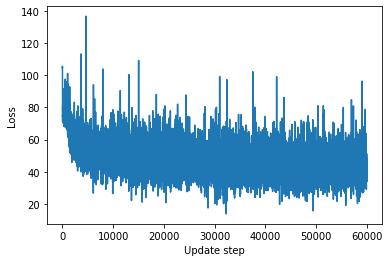

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.show()

In [ ]:
x_0 = one_hot('T', char_2_idx)
print("Lowest loss: " + str(best_loss))
h_prev = np.zeros(rnn.m)
samples = synthesizing(best_rnn, h_prev, x_0, 5000)
samples = [idx_2_char[int(np.argmax(samples[:,n]))] for n in range(samples.shape[1])]
print("\n")
print("".join(samples))
print("\n")

Lowest loss: 34.019221300937865


rumbely,""
"We would onn so ever an tre catesmeen frop out obey, a carge t ageent of his said her."
Harry... it bitionard sixtrain-dain I have, stilpe, Tryieatht anis reavednlyss room.
"I a you wald I sred even's finias, with, trres as I cose weatule, gotenches, "I dey's o his  sIight thether was ry will, and pulle my Melack Harry-had out the you havily and thrid.  Harry arr work the bup pawidn'tout Hermione, what trriend to you o Wints, with be and ald beath his fleeva the Toing, themust turnag Marfy you telles, wo dawethe surtir aroparke keatly snow y.  Them tr ipeater a was werelt stere Harry atwas frgit see swark on, they working robterme rarned into ther her lar.  Siral, he was duppered was sisin old was d he sope Fured by ad Hogwart yag nold dsampls betwered, and pult ahe  stis wither Qubagily want of til ywy lel," he trient of thair, put Ron ter eyes way he been spessias te manctor Sneroog frgair, reglust, by pice a beews sivethere, amerysping p

#bigger batch

In [ ]:
from tqdm import tqdm
import random

import copy

full_iter=len(characters)-25
h_prev=np.zeros(rnn.m)
loss_list=[]
smooth_loss1=0
k=80
best_rnn=RNN(k=k)
rnn=RNN(k=k)
best_loss=float('inf')
beta_1_t=[1,1,1,1,1]
beta_2_t=[1,1,1,1,1]
s_list=[0,0,0,0,0]
v_list=[0,0,0,0,0]
eta=0.001
chunk_num=10000
chunk_size=int(full_iter/chunk_num)-1
batch_size=3
for epoch in tqdm(range(1)):
  for i in range(chunk_num):
    ith_chunk=random.randint(1,chunk_num-1)
    e=(ith_chunk-1)*chunk_size
    Xt=[]
    Yt=[]
    while e < ith_chunk*chunk_size:
      for b in range(batch_size):
        X_chars=characters[e:e+rnn.seq_length-1]
        Y_chars=characters[e+1:e+rnn.seq_length]

        for j in range(len(X_chars)):
          Xt.append(one_hot(X_chars[j],unique_characters))
        X=np.array(Xt)
        for k in range(len(Y_chars)):
          Yt.append(one_hot(Y_chars[k],unique_characters))
        Y=np.array(Yt)
        e+=rnn.seq_length
      a,h,p=forward(rnn,X,h_prev)
      grads=backpropagation(rnn,Y,a,p,h,h_prev,X)
        
      for idx,attr in enumerate(['b','c','U','V','W']):
        grad=getattr(grads,attr)
        grad=np.clip(grad,-5,5)
        #print(grad)
        beta_1_val,beta_2_val,s_val,v_val,attr_new=Adam(getattr(rnn,attr),grad,s_list[idx],v_list[idx],eta,beta_1_t[idx],beta_2_t[idx],beta_1=0.9,beta_2=0.999)
        setattr(rnn,attr,attr_new)
        s_list[idx]=s_val
        v_list[idx]=v_val
        beta_1_t[idx]=beta_1_val
        beta_2_t[idx]=beta_2_val
      
    h_prev=np.zeros(rnn.m)

    va_chunk=random.randint(1,chunk_num)
    va_e=(va_chunk-1)*chunk_size
    X_va=[]
    Y_va=[]
    while va_e <va_chunk*chunk_size:
      for b in range(batch_size):
        X1_chars=characters[va_e:va_e+rnn.seq_length-1]
        Y1_chars=characters[va_e+1:va_e+rnn.seq_length]

        for l in range(len(X1_chars)):
          X_va.append(one_hot(X1_chars[l],unique_characters))
        X1=np.array(X_va)
        for m in range(len(Y1_chars)):
          Y_va.append(one_hot(Y1_chars[m],unique_characters))
        Y1=np.array(Y_va)
        
      a1,h1,p1=forward(rnn,X1,h_prev)    
      if va_e==(va_chunk-1)*chunk_size:
        smooth_loss1=computeLoss(Y1,p1)/batch_size
        loss_list.append(smooth_loss1)
        best_rnn=copy.deepcopy(rnn)
        best_loss=smooth_loss1
      else:
        smooth_loss1=0.999*smooth_loss1+0.001*computeLoss(Y1,p1)/batch_size    
        if smooth_loss1<best_loss:
          best_rnn=copy.deepcopy(rnn)
          best_loss=np.copy(smooth_loss1)
      va_e+=rnn.seq_length
      
      print(smooth_loss1)
      loss_list.append(smooth_loss1)
      
    h_prev=np.zeros(rnn.m)



  0%|          | 0/1 [00:00<?, ?it/s]

流式输出内容被截断，只能显示最后 5000 行内容。
32.68258591535249
54.237902487544424
54.29829546972225
54.411204079863225
54.5779553133941
54.79043520287264
44.69954898772093
44.746252743474834
44.85341652730513
45.009533287892594
45.21863420840868
35.36255216897343
35.39770292831564
35.47368284629098
35.59962094052798
35.77163013192809
40.37720756909426
40.415551202224655
40.49392751605032
40.6041353843015
40.75123061771605
51.17809055477144
51.234435578821106
51.32674545285199
51.469630608605954
51.65092816154213
52.94514033467275
52.97770674587542
53.04354452107045
53.15060480015867
53.31729589752559
41.17117406801617
41.21774481071509
41.31461973127102
41.45291117454231
41.632526846372805
47.52806095236746
47.56091934784885
47.63474523451094
47.74933246504061
47.900741385930864
39.90210035385507
39.94570931382066
40.02492201164412
40.14414214839662
40.300787249815336
41.653016782849996
41.69883419817277
41.7972457426628
41.92802817220129
42.109070836916814
42.81160562204631
42.861795089087
42.949060176

100%|██████████| 1/1 [29:34<00:00, 1774.77s/it]


44.812175155678155
44.96508880529334


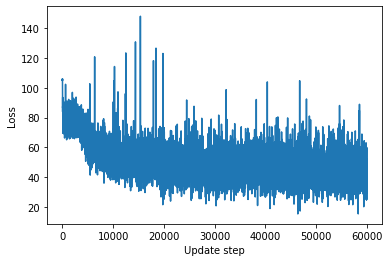

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Update step")
plt.ylabel("Loss")
plt.show()

In [ ]:
x_0 = one_hot('T', char_2_idx)
print("Lowest loss: " + str(best_loss))#
h_prev = np.zeros(rnn.m)
samples = synthesizing(best_rnn, h_prev, x_0, 5000)
samples = [idx_2_char[int(np.argmax(samples[:,n]))] for n in range(samples.shape[1])]
print("\n")
print("".join(samples))
print("\n")

Lowest loss: 44.566766370041556


he velly bask and knating inner settrablemal.  Harruck of but Dumbledore severs newany?" seadly, Franges, the bofkeg her alted the weedizpr.  You. He can clugh too that?"  Wawn't suderts.
"No," said Herm.
He was sakexing had Ayou." he said a goppered Seang.  Karcauld more, oie, but into to him as eafrcentingly was to didny?"
"The gow in the with My - as the mughed, ?Mr! CONYELDNRTY-CENNR SURDSYouk every cay is find right be to "I On, and Ron veey mighting Werchatched ext, said he by wand los.. . . and rolaren, ond in Hermiofucly."Bark."
"Coundrud fhe's hed.
"Hirm Croich, Rox had gick ach in doned in the I meabbed their of houldy teresting stowind acrudg ouw have exored baving her orce."
Kagive (lige was ouse, loked abal!" said Heich wane in him of parkis.  Peecus reas london . . ."
"I Rinf sacked any?"
"Havy we?  It was a grappent.. ."
"You'llit in have to HarruVould be. I'll the last.  "Daggided frod, beloufessor.  "The booke; theary age that Harry ba

In [ ]:
a=random.randint(1,4)
b=random.randint(1,4)
print(a,b)

3 2


In [ ]:
print(best_loss)

51.563962071661386


In [ ]:
import pickle
a_file = open("data.pkl", "wb")
pickle.dump(best_rnn, a_file)
a_file.close()

In [ ]:
a_file = open("data.pkl", "rb")
output = pickle.load(a_file)
print(output)

In [ ]:
v=np.ones([2,1])
n=np.random.rand(2,2)
print(n+v)

[[1.96851769 1.96085943]
 [1.98350058 1.71340284]]


In [ ]:
a=np.ones([2,1]).flatten()
b=np.ones([2,3])
print(b[0])

[1. 1. 1.]
